In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data_sulfur
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data_sulfur
from stesml.data_tools import get_test_data_sulfur

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.postprocessing_tools import get_h

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results_sulfur
from stesml.plot_tools import plot_average_error_sulfur
from stesml.plot_tools import plot_progress_results

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [20]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 1000
target = 'h'
per_case = False
x = 0

In [21]:
from typing import Tuple

def relu(x):
    return max(x,0)

def focal_obj(X_train):
    def custom_obj(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        rows = y.shape[0]
        zeros = np.zeros((rows), dtype=float)
        ones = np.ones((rows), dtype=float)
        grad = np.zeros((rows), dtype=float)
        hess = np.zeros((rows), dtype=float)
        Tw = X_train[:,1]
        Ti = X_train[:,2]
        # (y_hat - y)^2 + relu(Ti-y_hat) + relu(y_hat - Tw)
        grad = 4*(y_hat - y) - 0*np.maximum((Ti - y_hat),zeros) + 0*np.maximum((y_hat - Tw),zeros)
        hess = 4*ones + 0*np.maximum(np.sign(Ti - y_hat),zeros) + 0*np.maximum(np.sign(y_hat - Tw),zeros)
        grad = grad.reshape((rows, 1))
        hess = hess.reshape((rows, 1))
        return grad, hess
    return custom_obj

In [22]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data_sulfur(scenario_index, train_index, test_index, is_recurrent, target=target, per_case=per_case, x=x)
X_test, y_test = get_test_data_sulfur(scenario_index, test_index, is_recurrent, target=target, x=x)

In [23]:
model = get_model(model_type, n_estimators)

In [24]:
#from xgboost import XGBRegressor
#model = XGBRegressor(n_estimators=n_estimators, colsample_bylevel=.75, objective=focal_obj(X_train))

In [25]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [26]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [27]:
print(r2_score(y_test, y_hat))

0.9977545439439277


In [28]:
print(mean_squared_error(y_test, y_hat, squared=False))

2.490967687665265


In [74]:
test_df["h_hat"] = y_hat

In [40]:
y_hat

array([-2.9034984e+00,  4.4145928e+03,  4.4082886e+03, ...,
        3.0084457e+01,  3.0084457e+01,  3.0084457e+01], dtype=float32)

In [48]:
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As

In [125]:
def get_T(T_prev, h, Tw, timestep):
    Ac = get_Ac()
    m = get_m(T_prev, Ac)
    Cp = get_Cp(T_prev)
    As = get_As()
    slope = ( h*As*(Tw - T_prev) )/( m*Cp )
    T = slope*timestep + T_prev
    #print(m)
    
    return T

In [126]:
import matplotlib.pyplot as plt

[460.         459.99999973 460.00007666 ... 519.99992254 519.99992256
 519.99992257]


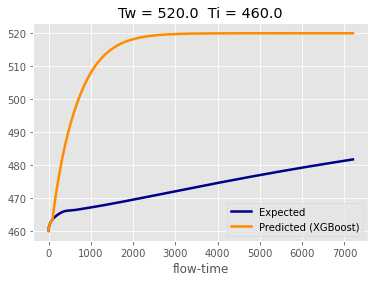

[460.         459.99999973 460.00012888 ... 559.99999553 559.99999553
 559.99999553]


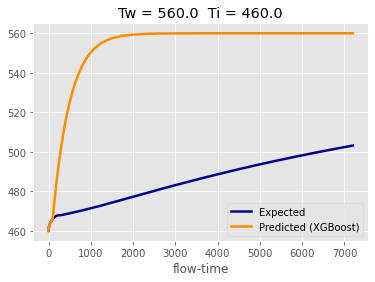

[480.         479.99999972 480.00011101 ... 559.9999975  559.99999751
 559.99999751]


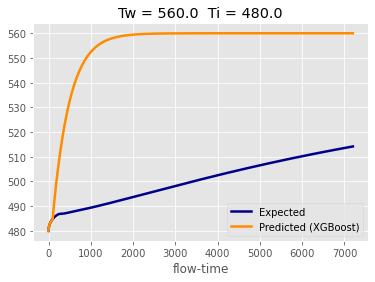

[500.         499.99999971 500.00008616 ... 559.99999815 559.99999815
 559.99999816]


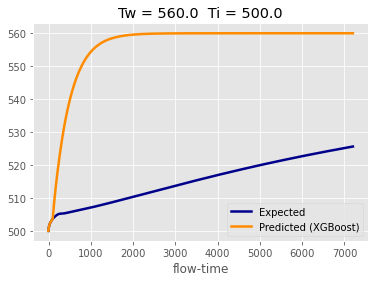

[540.         539.99999969 540.00003014 ... 559.99999682 559.99999682
 559.99999682]


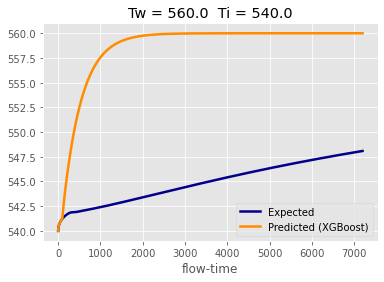

[460.         459.99999973 460.00007666 ... 559.99999682 559.99999682
 559.99999682]


In [127]:
T_hat = np.array([])
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    T_hat_grp = np.array([])
    Ti = grp["Ti"][0]
    Tw = grp["Tw"][0]
    T_hat_grp = np.append(T_hat_grp, Ti)
    T_prev = Ti
    for i, h in enumerate(grp["h_hat"]):
        if i == len(grp["h_hat"]) - 1:
            continue
        if i < 1000:
            T = grp["Tavg"][i]
            T_hat_grp = np.append(T_hat_grp, T)
            T_prev = T
            h_prev = h
            continue
        timestep = grp["flow-time"][i] - grp["flow-time"][i-1]
        T = get_T(T_prev, h_prev, Tw, timestep)
        T_hat_grp = np.append(T_hat_grp, T)
        T_prev = T
        h_prev = h
    print(T_hat_grp)
    grp["T_hat"] = T_hat_grp
    ax = grp.plot(x="flow-time", y='Tavg', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="flow-time", y='T_hat', c='DarkOrange', linewidth=2.5, label="Predicted ({model_type})".format(model_type=model_type), ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    #ax.set_xlim(0,100)
    plt.show()
    T_hat = np.concatenate((T_hat, T_hat_grp))
print(T_hat)

In [59]:
#test_df["T_hat"] = T_hat

In [29]:
#test_df = load_data(scenario_index, test_index, is_recurrent_test_data=True, is_train_data=False)
#h = get_h(test_df[5])

In [30]:
#import matplotlib.pyplot as plt
#window = 25
#average_h = []
#for ind in range(len(h) - window + 1):
#    average_h.append(np.mean(h[ind:ind+window]))
    
#plt.plot(h)

In [69]:
test_df = load_data_sulfur(scenario_index, test_index, x=x)
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent)

In [70]:
#plot_average_error_sulfur(test_df_plot)

<AxesSubplot:>

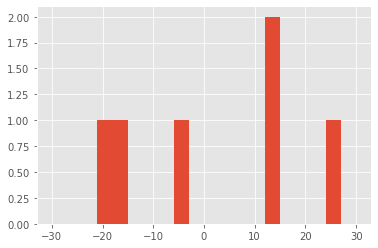

In [71]:
(test_df_plot["Tavg"] - test_df_plot["Tc_hat"]).hist(bins=20, range=(-30, 30))

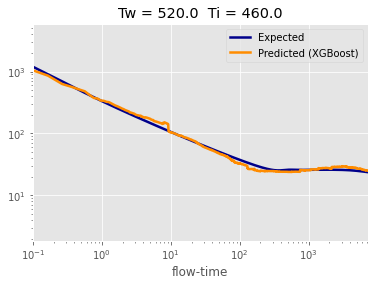

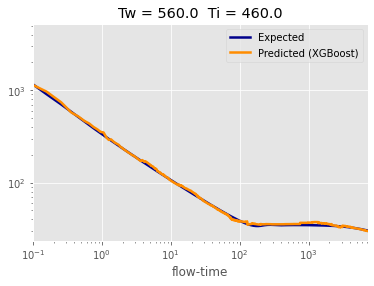

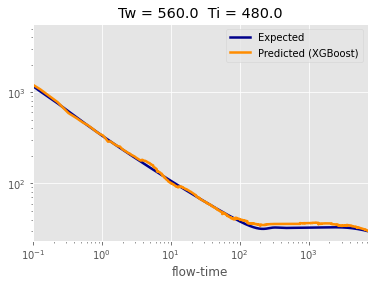

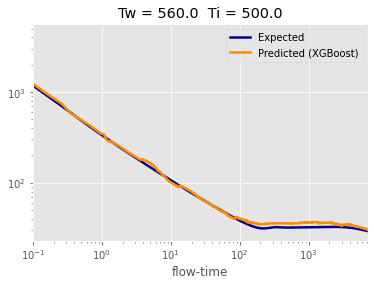

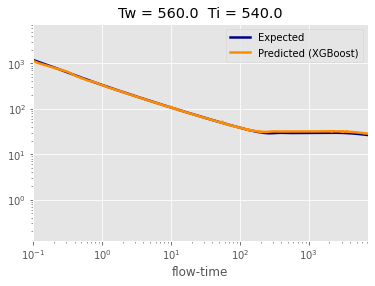

In [72]:
plot_test_results_sulfur(test_df_plot, model_type, target=target)

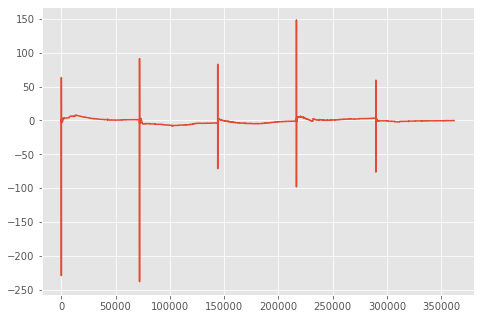

In [76]:
import matplotlib.pyplot as plt
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(y_test-y_hat)
#ax.set_yscale('log')
plt.show()

In [77]:
min_estimators = 10
max_estimators = 11
step_size = 2
num_shuffle_iterations = 100

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent, verbose=True, target=target, per_case=per_case, x=x)

0
Predicted: [ 316.07376 3313.4346  3313.4346  ...   29.04948   29.04948   29.04948]
Expected: [   0.         3668.38031643 3663.41364101 ...   30.23229833   30.23222151
   30.23218422]
1
Predicted: [  29.117592 3602.5146   3602.5146   ...   21.989742   21.989742
   21.989742]
Expected: [   0.         3668.86628447 3664.38943667 ...   22.79200817   22.79196012
   22.79191613]
2
Predicted: [  31.130257 3605.1265   3605.1265   ...   29.092426   29.092426
   29.092426]
Expected: [   0.         3669.11455896 3664.89090661 ...   30.23229833   30.23222151
   30.23218422]
3
Predicted: [  63.728172 4184.6484   4184.6484   ...   22.077988   22.077988
   22.077988]
Expected: [   0.         4306.2788931  4300.17823117 ...   25.05571994   25.0555973
   25.05548041]
4
Predicted: [  32.09435  3645.3105   3645.3105   ...   29.536829   29.536829
   29.536829]
Expected: [   0.         3669.11455896 3664.89090661 ...   26.4223336    26.42225858
   26.42223849]
5
Predicted: [  78.13069  4143.1846   4143.

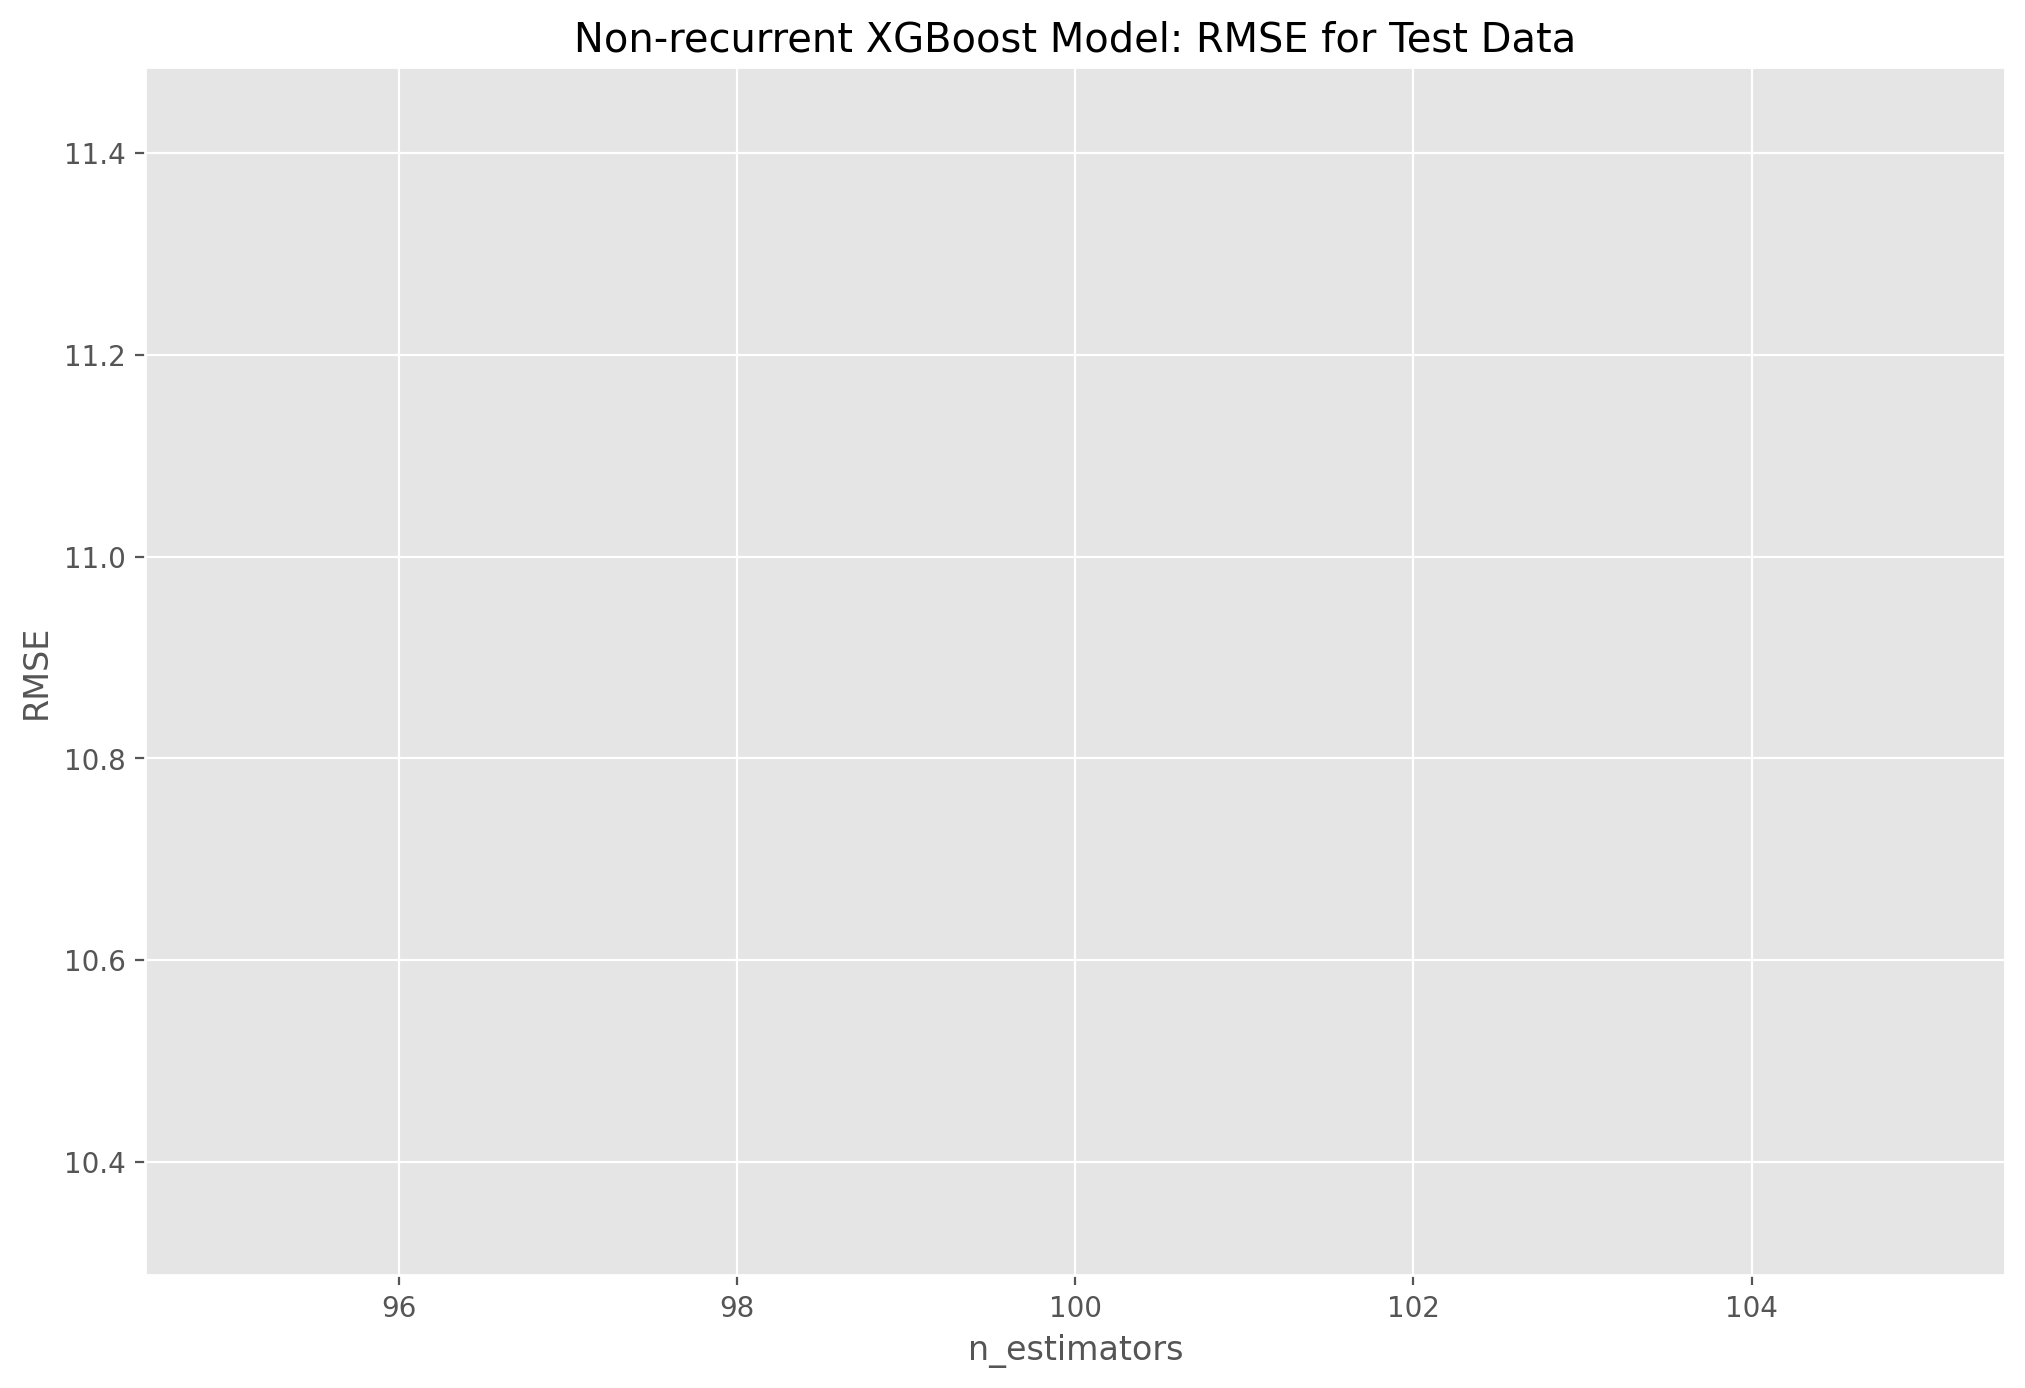

In [21]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

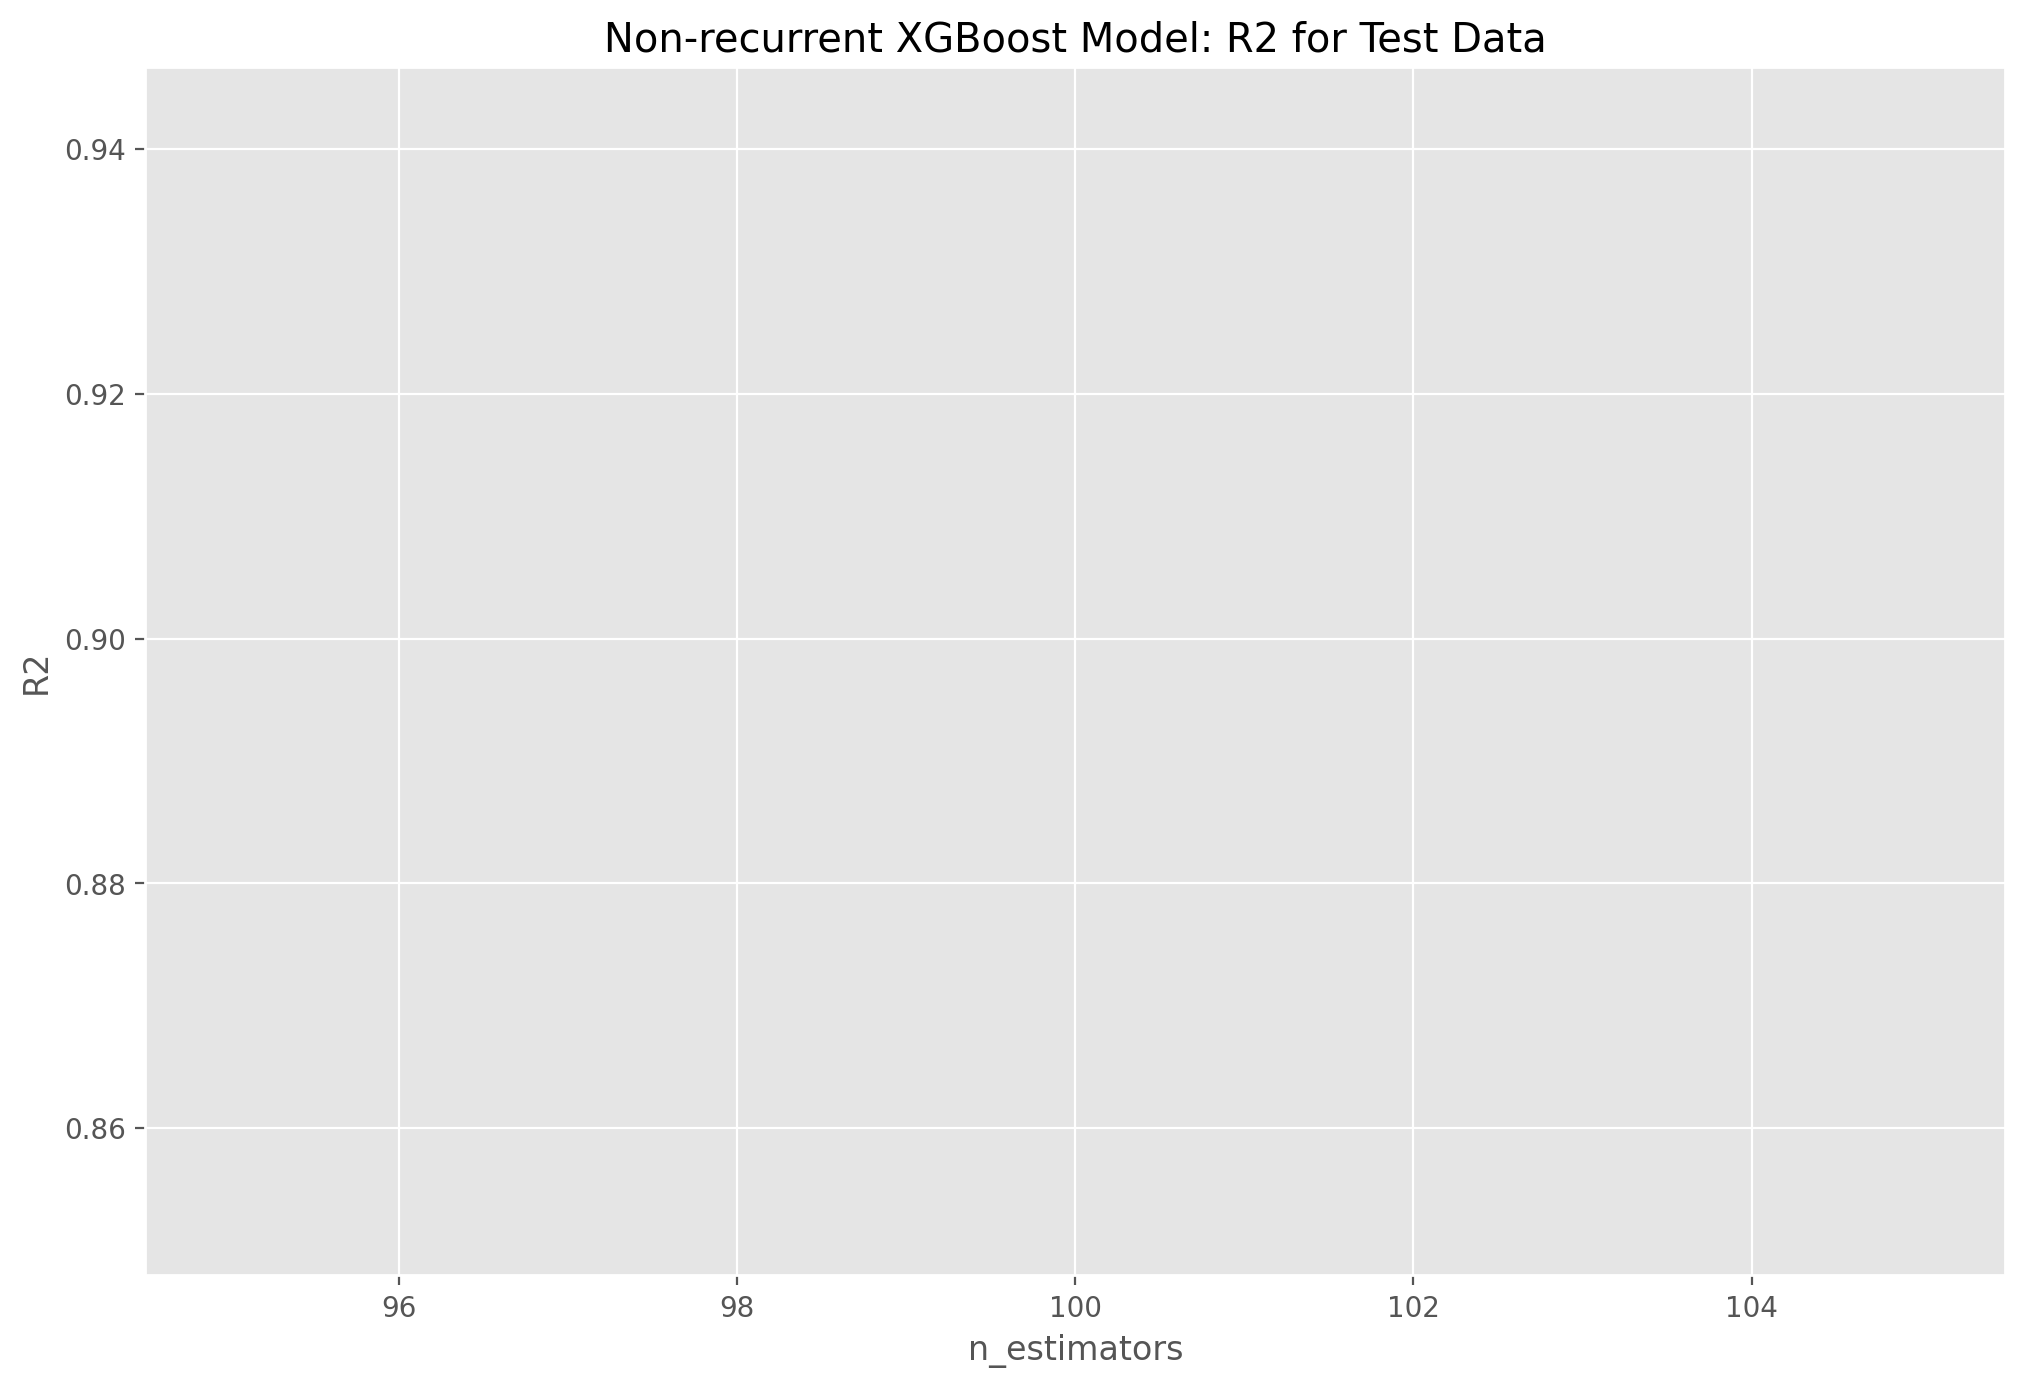

In [55]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")